<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Basic-image-statistics" data-toc-modified-id="Basic-image-statistics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Basic image statistics</a></span><ul class="toc-item"><li><span><a href="#Weighted-averages" data-toc-modified-id="Weighted-averages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Weighted averages</a></span></li><li><span><a href="#Verify-with-random-numbers" data-toc-modified-id="Verify-with-random-numbers-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Verify with random numbers</a></span></li><li><span><a href="#Example:-Far-infrared-images-of-the-GN-z11-field" data-toc-modified-id="Example:-Far-infrared-images-of-the-GN-z11-field-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Example: Far-infrared images of the GN-z11 field</a></span><ul class="toc-item"><li><span><a href="#Question:" data-toc-modified-id="Question:-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Question:</a></span></li></ul></li></ul></li><li><span><a href="#Hubble-Space-Telescope-images" data-toc-modified-id="Hubble-Space-Telescope-images-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Hubble Space Telescope images</a></span><ul class="toc-item"><li><span><a href="#Source-detection-and-image-segmentation" data-toc-modified-id="Source-detection-and-image-segmentation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Source detection and image segmentation</a></span><ul class="toc-item"><li><span><a href="#Question:" data-toc-modified-id="Question:-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Question:</a></span></li></ul></li><li><span><a href="#Profile-fits" data-toc-modified-id="Profile-fits-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Profile fits</a></span></li></ul></li><li><span><a href="#Exercise" data-toc-modified-id="Exercise-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exercise</a></span></li></ul></div>

# Basic image statistics

This notebook shows some basic tools for interpreting telescope images of distant galaxies, taking the example of the distant galaxy GNz11 in the "GOODS-North" survey field from the Hubble Space telescope [(Oesch et al. 2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...819..129O/abstract).

In [1]:
# If you need it

!pip install scikit-image

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.interpolation'] = 'Nearest'
plt.rcParams['image.origin'] = 'lower'

import scipy.stats

## Weighted averages

We'll use a simple technique throughout to compute weighted averages of quantities where we have (1D, 2D) arrays of noisy measurements and corresponding arrays of the uncertainties estimated from knowledge of the detector characteristics.  

For convenience, we'll frequently define inverse variance weight arrays

$\mathrm{w} = 1/\sigma^2$, 

so that dividing by $\sigma^2$ is rather a multiplicative operation (and where missing data is naturally described by $\mathrm{w} = 0$.

For data $x_i$ with weights $w_i = 1 / \sigma_i^2$, the weighted average of $x$ is

$\bar x = \sum(x_i w_i) / \sum(w_i)$. 

with variance

$s^2 = 1 / \sum(w_i)$.

## Verify with random numbers

In [3]:
Ndraws = 10000
Ntrials = 1000

xbar = np.zeros(Ntrials)
s2 = np.zeros(Ntrials)

for i in range(Ntrials):
    # Unequal uncertainties
    sig = np.random.rand(Ndraws)+1
    rvs = np.random.normal(size=Ndraws)*sig
    w = 1/sig**2
    xbar[i] = (rvs*w).sum()/w.sum()
    s2[i] = 1/w.sum()
    

AndersonResult(statistic=0.29417735514800825, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

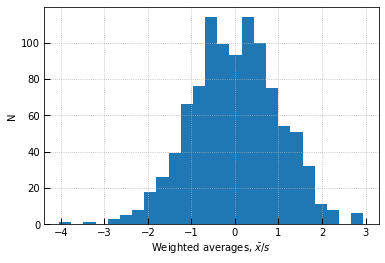

In [4]:
# Are the computed averages normally distributed given 
# their calculated variances?
_h = plt.hist(xbar/np.sqrt(s2), bins=25)
plt.grid()
plt.xlabel(r'Weighted averages, $\bar{x}/s$')
plt.ylabel('N')

scipy.stats.anderson(xbar/np.sqrt(s2))

## Example: Far-infrared images of the GN-z11 field

The field around GN-z11 was observed with the Scuba2 instrument on the James Clerk Maxwell telescope at a wavelength of 850 µm.  The background at these wavelengths is generally **much** brighter than the sources of interest, so many exposures are taken and averaged to make the final map.

The images are created with pixels 4 arcseconds on a side, and GN-z11 is at the center of the image at approximate location ``(x, y) = (27, 44)``.


In [5]:
# Image data
scuba2 = np.load('scuba2.npy', allow_pickle=True)[0]
print('Keys: ', scuba2.keys())
for k in scuba2:
    print(k, scuba2[k].shape)
    
Nexp, ydim, xdim = scuba2['intensity'].shape

Keys:  dict_keys(['intensity', 'weight', 'exposure_time'])
intensity (275, 72, 72)
weight (275, 72, 72)
exposure_time (275,)


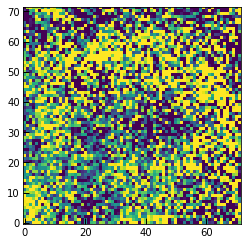

In [6]:
# Show the first exposure
plt.imshow(scuba2['intensity'][0,:,:], vmin=-10, vmax=10)

AndersonResult(statistic=0.22654166802931286, critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

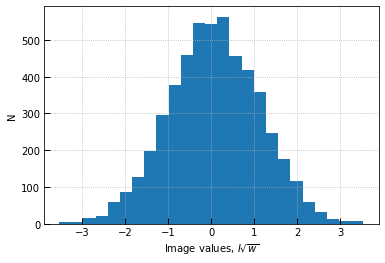

In [7]:
# Is the noise of a single exposure Gaussian?
scaled_noise = scuba2['intensity']*np.sqrt(scuba2['weight'])
_h = plt.hist(scaled_noise[0,:,:].flatten(), bins=25)

plt.grid()
plt.xlabel(r'Image values, $I \sqrt{w}$')
plt.ylabel('N')

scipy.stats.anderson(scaled_noise[0,:,:].flatten())


In [8]:
# Cumulative weighted average
cumul_num = np.cumsum(scuba2['intensity']*scuba2['weight'], axis=0)
cumul_den = np.cumsum(scuba2['weight'], axis=0)

cumul_intensity = cumul_num/cumul_den
cumul_var = 1/cumul_den

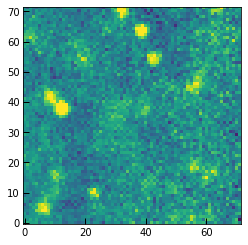

In [55]:
# Show the final weighted image
plt.imshow(cumul_intensity[-1,:,:], vmin=-3, vmax=3)

How does the median weight ($1/s^2$) of the weighted stack 
change with time?

We found that signal-to-noise ($\bar{x}/s$) goes as $\sqrt t$, so weight should increase linearly in time.

In [10]:
cumul_weight = 1/cumul_var # = cumul_den = sum of weights

median_wht = [np.median(cumul_weight[i,:,:]) for i in range(Nexp)]

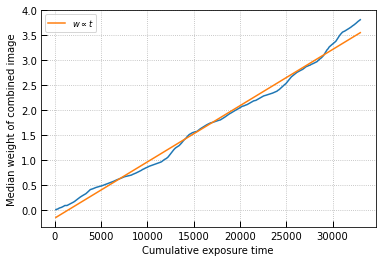

In [11]:
# Fit with a line (weight linear in time is 1/sqrt(s) time as expected
cumul_time = np.cumsum(scuba2['exposure_time'])

plt.plot(cumul_time, median_wht)

_c = np.polyfit(cumul_time, median_wht, 1)
plt.plot(cumul_time, np.polyval(_c, cumul_time), label=r'$w\propto t$')
plt.xlabel('Cumulative exposure time')

plt.ylabel('Median weight of combined image')

plt.legend()
plt.grid()

### Question:

Is the noise of the stack Gaussian?

AndersonResult(statistic=53.22850640048637, critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

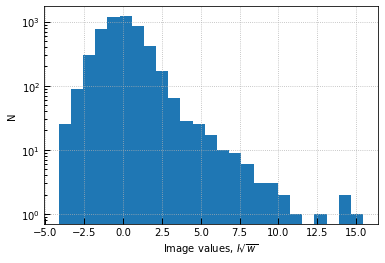

In [33]:
scaled_noise = cumul_intensity / np.sqrt(cumul_var)

_h = plt.hist(scaled_noise[-1,:,:].flatten(), bins=25, log=True)

plt.grid()
plt.xlabel(r'Image values, $I \sqrt{w}$')
plt.ylabel('N')

scipy.stats.anderson(scaled_noise[-1,:,:].flatten())

AndersonResult(statistic=82.09476964268833, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

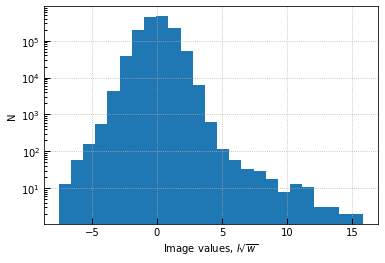

In [53]:
# Is this the same as all pixels separately?

scaled_noise_full = (scuba2['intensity']*np.sqrt(scuba2['weight']))[:,:,:].flatten()

_h = plt.hist(scaled_noise_full, bins=25, log=True)

plt.grid()
plt.xlabel(r'Image values, $I \sqrt{w}$')
plt.ylabel('N')

scipy.stats.anderson(scaled_noise_full)

# Hubble Space Telescope images

The data provided here are cutouts from Hubble images around the position of the galaxy GN-z11.  Images are provided in four bandpass filters, named like 

- f105w: Centered at 1.05 µm
- f125w: 1.25 µm
- f140w: 1.40 µm
- f160w: 1.60 µm

The images are created with pixels 0.125 arcseconds on a side, and GN-z11 is at the center of the image at approximate location ``(x, y) = (119, 119)``.

In [12]:
hst_data = np.load('gnz11-hst_cutouts.npy', allow_pickle=True)[0]

galaxy_models, psfs, flux_scale, exptime = np.load('gnz11-hst_extra.npy', 
                                                   allow_pickle=True)
print(hst_data.keys())
print(hst_data['f160w'].keys())

hst_dim = galaxy_models['f160w'].shape
print('Image dimensions: ', hst_dim)

dict_keys(['f105w', 'f125w', 'f140w', 'f160w'])
dict_keys(['intensity', 'weight'])
Image dimensions:  (240, 240)


## Source detection and image segmentation

Make a threshold image that provides an estimate of the S/N of a point source at every position in the image. 

Then run peak-finding and segmentation algorithms to "segment" the image into discrete sources (e.g., [skimage.segmentation.watershed](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html)).

In [13]:
# Segmentation
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import binary_dilation

from scipy import ndimage as ndi

peak_threshold = 7
segment_threshold = 2.5

#peak_threshold = 3
#segment_threshold = 1.2

# Run detection on F160W image
filt = 'f160w'

/Users/gbrammer/miniconda3/envs/grizli-dev-2020.1/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


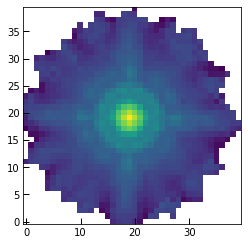

In [14]:
# Show a PSF
plt.imshow(np.log10(psfs['f160w']))

In [15]:
from scipy.signal import fftconvolve

# SN image: intensity convolved with the PSF
psf = psfs[filt]
data = hst_data[filt]

sm_num = fftconvolve(data['intensity']*data['weight'], psf, mode='same')
sm_den = fftconvolve(data['weight'], psf**2, mode='same')
SN = sm_num/np.sqrt(sm_den)


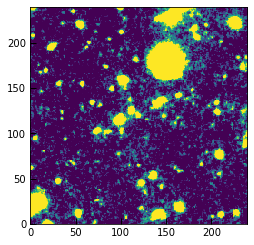

In [16]:
plt.imshow(SN, vmin=0, vmax=5)

In [17]:
# Find local maxima (sources) above the defined threshold
coords = peak_local_max(SN, footprint=np.ones((5, 5)), 
                        threshold_abs=peak_threshold, 
                        labels=None)

# Point labels
peak_mask = np.zeros(SN.shape, dtype=bool)
peak_mask[tuple(coords.T)] = True
markers, _ = ndi.label(peak_mask)

# Mask for segmentation
SN_mask = SN > segment_threshold

labels = watershed(-SN, markers, mask=SN_mask)

# Grow the segments slightly
grow = np.ones((3,3), dtype=bool)
empty = binary_dilation(labels > 0, selem=grow) == 0

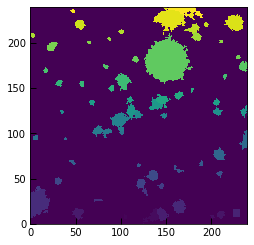

In [18]:
plt.imshow(labels)

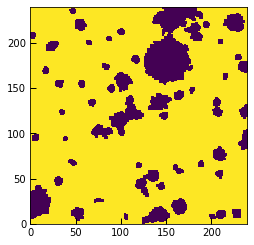

In [19]:
plt.imshow(empty)

In [20]:
# Is the noise Gaussian?

AndersonResult(statistic=0.3550440841947875, critical_values=array([0.573, 0.653, 0.784, 0.914, 1.087]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

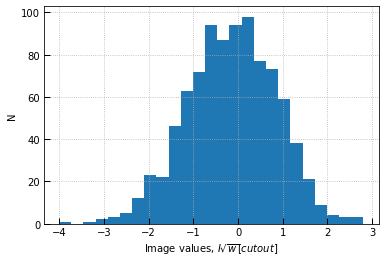

In [21]:
# Subregion that looks empty
slx = slice(58, 93)
sly = slice(39, 65)

resid = data['intensity']*np.sqrt(data['weight'])

_h = plt.hist(resid[sly, slx].flatten(), bins=25)

plt.grid()
plt.xlabel(r'Image values, $I \sqrt{w} [cutout]$')
plt.ylabel('N')

scipy.stats.anderson(resid[sly, slx].flatten())

### Question:

1) Are empty parts of the entire image consistent with Gaussian noise?  
2) If not, why might that be?

The histogram of the "empty' parts of the image is skewed towards positive values, and the Anderson-Darling statistic is very large suggesting non-Gaussianity.  These are mostly sources that weren't detected based on our detection thresholds, or the outer profiles of detected sources that fell below the segmentation thresholds but nevertheless has significant (integrated) signal.

Lowering the threshold will find some of them, but as some level there will always be sources just below the detection threshold that bias fluxes positive.  The example data provided here has been background-subtracted with something like a (masked) median of the original images.  Such a median will be biased somewhat high, depending on the relative depth of the image and the flux distribution of faint sources.

Gaussian fit:  (-0.09367892, 1.044314)


AndersonResult(statistic=167.84696796200296, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

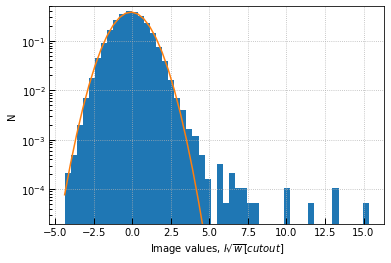

In [56]:
# use "empty" mask created above to define image 
# regions without (bright) sources

_h = plt.hist(resid[empty].flatten(), bins=50, log=True, density=True)

plt.grid()
plt.xlabel(r'Image values, $I \sqrt{w} [cutout]$')
plt.ylabel('N')

nfit = scipy.stats.norm.fit(resid[empty].flatten())
print('Gaussian fit: ', nfit)
plt.plot(_h[1], scipy.stats.norm.pdf(_h[1], *nfit), label='Gaussian fit')

plt.ylim(2.e-5, 0.5)

scipy.stats.anderson(SN[empty].flatten())

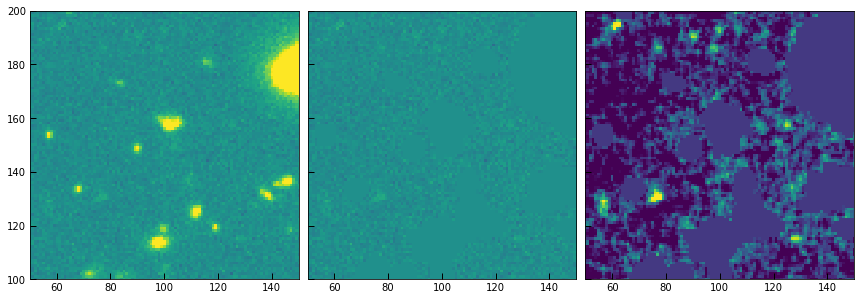

In [57]:
fig, axes = plt.subplots(1,3, figsize=(12, 4), sharey=True)

axes[0].imshow(data['intensity'], vmin=-0.1, vmax=0.1)
axes[1].imshow(data['intensity']*empty, vmin=-0.1, vmax=0.1)
axes[2].imshow(SN*empty, vmin=-1, vmax=5)

for ax in axes:
    ax.set_xlim(50, 150)
    ax.set_ylim(100, 200)

fig.tight_layout(pad=0.8)

## Profile fits

Fitting linear models to data looks a lot like the weighted least-squares example shown above.  

Consider the linear model

$y = A x$, 

where $A$ is a scalar and the intercept is assumed to be zero.  The weighted least squares solution for $A$ is:

$A = \sum{x_i y_i w_i} / \sum{x_i^2 w_i}$, 

with variance, 

$s_A^2 =  1 / \sum{x_i^2 w_i}$.

This identical to the weighted average defined at the top where $x_i = 1$, i.e., a weighted sum.  And it's the same equation that appeared in the PSF convolution, but where in that case $x_{ij}$ is the 2D PSF and the convolution provides the sum over the PSF pixels.

Here I have provided a full 2D spatial model, $M(\lambda)$ of the GN-z11 source derived with other fitting software, as it is slightly resolved and not consistent with being the unresolved PSF.  Specifically, it is fit with a 2D "[Sersic](https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Sersic2D.html)" profile convolved with the PSF.  

Assuming this model is correct, the minimum variance estimate of the total intensity of the source can be derived with this spatial profile as a weighting function (analogous to the discussion in [Horne 1986](https://ui.adsabs.harvard.edu/abs/1986PASP...98..609H/abstract)).  

The total profile-fit source intensity $S$ is computed with

$S = \sum{M_{ij} I_{ij} W_{ij}}\ /\ \sum{M_{ij}^2 W_{ij}}$, 

where $I_{ij}$ and $W_{ij}$ are the 2D intensity and weight images, respectively, for a given bandpass filter.





In [24]:
model = galaxy_models[filt]
model /= model.sum() # Normalize the model to unity

In [25]:
# Object / segment ID of GNz11
obj_id = labels[120,120]
print('ID: ', obj_id)
obj_mask = binary_dilation(labels == obj_id, selem=grow)

src_num = (data['intensity']*model*data['weight']*obj_mask).sum()
src_den = (model**2*data['weight']*obj_mask).sum()

# Units are 1e-7 Jansky
calib = flux_scale[filt]

total_intensity = src_num/src_den*calib
total_uncertainty = 1/np.sqrt(src_den)*calib

print(f'{filt} intensity: {total_intensity:.2f} {total_uncertainty:.2f}')

ID:  33
f160w intensity: 1.50 0.04


# Exercise

1) Make a plot that shows the image, model, and residual

2) Measure the profile-fit fluxes in the other bands and plot the Spectral Energy Distribution (wavelength vs. filter flux)

3) Does this look like a Lyman Break Galaxy?

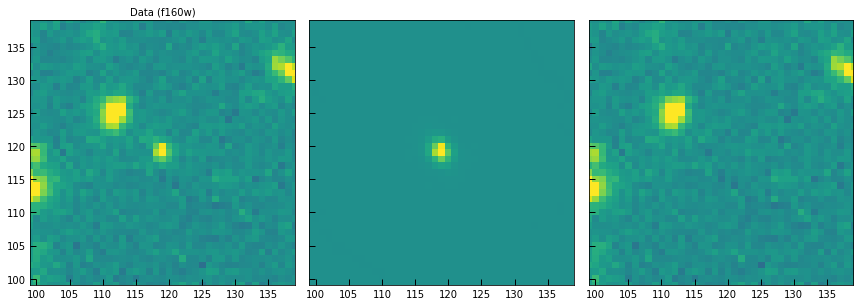

In [26]:
# 1)

fit_model = model*total_intensity/calib

fig, axes = plt.subplots(1,3, figsize=(12, 4), sharey=True)

axes[0].imshow(data['intensity'], vmin=-0.1, vmax=0.1)
axes[0].set_title(f'Data ({filt})')

axes[1].imshow(fit_model, vmin=-0.1, vmax=0.1)
axes[0].set_title(f'Data ({filt})')

axes[2].imshow(data['intensity'] - fit_model, vmin=-0.1, vmax=0.1)

for ax in axes:
    ax.set_xlim(119-20, 119+20)
    ax.set_ylim(119-20, 119+20)

fig.tight_layout(pad=0.8)


In [27]:
flux = []
unc = []

for filt in galaxy_models:
    model = galaxy_models[filt]
    model /= model.sum()
    
    data_i = hst_data[filt]

    src_num = (data_i['intensity']*model*data_i['weight']*obj_mask).sum()
    src_den = (model**2*data_i['weight']*obj_mask).sum()

    # Units are 1e-7 Jansky
    calib = flux_scale[filt]

    total_intensity = src_num/src_den*calib
    total_uncertainty = 1/np.sqrt(src_den)*calib
    
    flux.append(total_intensity)
    unc.append(total_uncertainty)
    
    print(f'{filt} intensity: {total_intensity:.2f} {total_uncertainty:.2f}')

f105w intensity: -0.03 0.05
f125w intensity: 0.07 0.03
f140w intensity: 0.72 0.04
f160w intensity: 1.50 0.04


1.601917096099441e-05
2.3254852403036274e-07
0.05606847641002299
0.1430601001794812


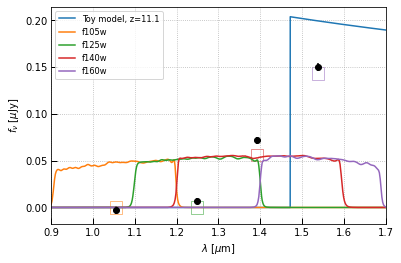

In [28]:

wavelengths = np.array([1.055, 1.2486, 1.3922, 1.5369])
plt.errorbar(wavelengths, np.array(flux)*0.1, np.array(unc)*0.1, linestyle='None', 
             marker='o', color='k')

# You won't have this necessarily, tools for dealing with HST
# filters and spectra (https://pysynphot.readthedocs.io/en/latest/)
import pysynphot as S

# Simple Lyman Break step-function model
ztest = 11.1

xrest = np.arange(100, 2800., 0.1)
yrest = (xrest > 1216)*(xrest*(1+ztest)/1.6e4)**-0.5*1.3

plt.plot(xrest*(1+ztest)/1.e4, yrest*flux[-1]*0.1, label=f'Toy model, z={ztest:.1f}')

spec = S.ArraySpectrum(xrest*(1+ztest), yrest*flux[-1]*0.1, fluxunits='uJy')

for filt in galaxy_models:
    bp = S.ObsBandpass(f'wfc3,ir,{filt}')
    pl = plt.plot(bp.wave/1.e4, bp.throughput*0.1, label=filt)
    
    obs = S.Observation(spec, bp)
    counts = obs.countrate()
    print(counts*flux_scale[filt]*0.1)
    plt.scatter(bp.pivot()/1.e4, counts*flux_scale[filt]*0.1, fc='None', ec=pl[0].get_color(), 
                marker='s', alpha=0.5, s=150)
    
plt.legend()
plt.xlim(0.9, 1.7)
plt.ylim()
plt.xlabel(r'$\lambda$ [$\mu\mathrm{m}$]')
plt.ylabel(r'$f_\nu$ [$\mu\mathrm{Jy}$]')
plt.grid()
